# CRF sequence tagging for Movie Queries

Optimized the performance of a **Conditional Random Field (CRF) sequence tagger** for movie trivia questions and answers data, which consist of instances of data of word sequences with the target classes/labels for each word in a **BIO (Beginning, Inside, Outside)** tagging format. 

Read in, pre-processed, trained and developed the tagger on the training data from *trivia10k13train.bio.txt*, and finally tested the tagger on the data *trivia10k13test.bio.txt*, attempting to get the best performing tagger across the different labels in our development process. Optimize the performance of the tagger by improving its feature extraction function on the word sequences, incorporating POS tagging first, then optimized the performance by all legal means neccessary (except looking at the test data). 



In [ ]:
# You may need to run this first- uncomment if so
!pip install python-crfsuite

     |████████████████████████████████| 743 kB 4.2 MB/s 


In [ ]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [ ]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [ ]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [ ]:
# have a look at the first example
print(raw_training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [ ]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

7816 instances
158823 words


# Splitting the training data into 80% training, 20% development set



In [ ]:
from sklearn.model_selection import train_test_split

train_80_split, test_20_split = train_test_split(raw_training_data, test_size=0.2, random_state=1)

In [ ]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  #trivial- no preprocessing

    #tokens =["@".join(pos) for pos in posttagger.tag([word[0] for word in example])] #using CRF part-of-speech (POS) tagger to join tokens with POS tags
    #tags = [t[1] for t in example] #extracting BIO tags from the sentence to a list
    #preprocessed_example=list(zip(tokens, tags)) # zipping both lists together

    return preprocessed_example

Using the 80% of the split for training

In [ ]:
training_data = [preProcess(example) for example in train_80_split]

In [ ]:
# check the effect of pre-processing
print(training_data[0])

[('what', 'O'), ('s', 'O'), ('the', 'O'), ('camp', 'B-Genre'), ('comedy', 'I-Genre'), ('musical', 'I-Genre'), ('classic', 'I-Genre'), ('that', 'O'), ('features', 'O'), ('susan', 'B-Actor'), ('sarandon', 'I-Actor'), ('s', 'O'), ('first', 'O'), ('role', 'O'), ('and', 'O'), ('the', 'O'), ('song', 'O'), ('time', 'B-Soundtrack'), ('warp', 'I-Soundtrack')]


In [ ]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token=tokens[idx]
    
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    

    #print(feature_list)
    return feature_list

In [ ]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function
print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [ ]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [ ]:
# an example from the corpus
example = "steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies"
print_tags(example)

steve       B-Actor
mcqueen     I-Actor
provided    O
a           B-Plot
thrilling   I-Plot
motorcycle  I-Plot
chase       I-Plot
in          I-Plot
this        I-Plot
greatest    I-Plot
of          I-Plot
all         I-Plot
ww          I-Plot
2           I-Plot
prison      I-Plot
escape      I-Plot
movies      I-Plot


In [ ]:
# a novel, unseen example we've just made up
print_tags("batman is the main character in batman begins")

batman      O
is          O
the         O
main        O
character   O
in          O
batman      B-Character_Name
begins      I-Character_Name


In [ ]:
# another example
print_tags("the sound of music")

the         O
sound       O
of          O
music       O


In [ ]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1953 instances
39035 words


In [ ]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


# Error analysis 1: False positives
Testing tagger for 20% split test data: 

In [ ]:
 
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

test_data_20 = [preProcess(example) for example in test_20_split]
print(len(test_data_20), "instances")
print(sum([len(sent) for sent in test_data_20]), "words")

print("testing tagger for 20% test data split...")
preds_20 = []
y_test_20 = []
for sent in test_data_20: 
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_20.extend(sent_preds)
    y_test_20.extend(sent_true)
print("done")




1564 instances
31890 words
testing tagger for 20% test data split...
done


Converted the classification report after testing on the 20% split to a dataframe to retrieve the lowest five precision classes

In [ ]:
#Classes with lowest precision
import pandas as pd

report = classification_report(y_test_20, preds_20, output_dict=True)
df = pd.DataFrame(report).transpose()

print("Classes with lowest precision: ")

df.sort_values(by=['precision'])[0:5]


Classes with lowest precision: 


,precision,recall,f1-score,support
B-Soundtrack,0.000000,0.000000,0.000000,12.0
B-Quote,0.272727,0.107143,0.153846,28.0
I-Soundtrack,0.363636,0.121212,0.181818,33.0
B-Origin,0.390476,0.277027,0.324111,148.0
I-Opinion,0.391304,0.129496,0.194595,139.0


In [ ]:
#Error analysis 1: False positives for the above lower precision classes

count_falsepos={} #Dictionary to validate the number of sentences containing false positive for the lowest precision  classes
for tag_low_precision in df.sort_values(by=['precision'])[0:5].index:
    num_sent=0 #sentence counter for each class
    for sent in test_data_20: 
      sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])] #Predicted values
      sent_true = [s[1] for s in sent]  #True values
      sent_words = [s[0] for s in sent] 
      for pred_val, true_val, word in zip(sent_preds, sent_true,sent_words):
        if(tag_low_precision == pred_val and pred_val!= true_val):
          print("False positive of",tag_low_precision,"class:")
          print("Sentence:"," ".join([s[0] for s in sent]))
          print(f'Word:{word}\nPredicted class: {pred_val:12s}\nTrue class: {true_val}\n') 
          num_sent+=1
    count_falsepos[tag_low_precision]=num_sent

False positive of B-Soundtrack class:
Sentence: this black and white comedy directed by mel brooks stars gene wilder and peter boyle and features the classic song puttin on the ritz
Word:classic
Predicted class: B-Soundtrack
True class: B-Genre

False positive of B-Quote class:
Sentence: you have one week to have sex with whoever you want and i wont get mad
Word:you
Predicted class: B-Quote     
True class: B-Plot

False positive of B-Quote class:
Sentence: this 1932 mgm classic won the academy award for best picture and featured greta garbo speaking her legendary line but i want to be alone
Word:greta
Predicted class: B-Quote     
True class: B-Actor

False positive of B-Quote class:
Sentence: in what science fiction movie does arnold use the classic catch phrase i ll be back
Word:use
Predicted class: B-Quote     
True class: O

False positive of B-Quote class:
Sentence: if it s beginning to look a lot like christmas there is no avoiding this james stewart film
Word:if
Predicted class

# Error analysis 2: False negatives
Retrieved the lowest five recall classes:

In [ ]:
#Classes with lowest recall

print("Classes with lowest recall: ")

df.sort_values(by=['recall'])[0:5]

Classes with lowest recall: 


,precision,recall,f1-score,support
B-Soundtrack,0.000000,0.000000,0.000000,12.0
B-Quote,0.272727,0.107143,0.153846,28.0
I-Soundtrack,0.363636,0.121212,0.181818,33.0
I-Opinion,0.391304,0.129496,0.194595,139.0
I-Character_Name,0.638889,0.146497,0.238342,157.0


In [ ]:
#Error analysis 2: False negatives for the above lower recall classes

count_falseneg={} #Dictionary to validate the number of sentences containing false negative for the lowest recall  classes
for tag_low_recall in df.sort_values(by=['recall'])[0:5].index:
    num_sent=0 #sentence counter for each class
    for sent in test_data_20: 
      sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])] #Predicted values
      sent_true = [s[1] for s in sent]  #True values
      sent_words = [s[0] for s in sent] 
      for pred_val, true_val, word in zip(sent_preds, sent_true,sent_words):
        if(tag_low_recall == true_val and pred_val!= true_val):
          print("False negative of",tag_low_recall,"class:")
          print("Sentence:"," ".join([s[0] for s in sent]))
          print(f'Word:{word}\nPredicted class: {pred_val:12s}\nTrue class: {true_val}\n') 
          num_sent+=1
    count_falseneg[tag_low_recall]=num_sent
        
  

False negative of B-Soundtrack class:
Sentence: irving berlin s song white christmas was written for this 1942 movie starring bing crosby and fred astaire
Word:white
Predicted class: I-Soundtrack
True class: B-Soundtrack

False negative of B-Soundtrack class:
Sentence: what is the name of the movie in which christina aguilera pink mya and lil kim collaborated for the lead music track of the film
Word:collaborated
Predicted class: O           
True class: B-Soundtrack

False negative of B-Soundtrack class:
Sentence: the movie about lions that disney made that has the song hakunamatata in it from the 1990 s
Word:hakunamatata
Predicted class: O           
True class: B-Soundtrack

False negative of B-Soundtrack class:
Sentence: what movie featured songs co written by elton john including hakuna matata and can you feel the love tonight
Word:hakuna
Predicted class: B-Actor     
True class: B-Soundtrack

False negative of B-Soundtrack class:
Sentence: what movie featured songs co written by 

In [ ]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=90)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

Sentences with False positive: {'B-Soundtrack': 1, 'B-Quote': 8, 'I-Soundtrack': 7, 'B-Origin': 64, 'I-Opinion': 28}
Sentences with False negative: {'B-Soundtrack': 12, 'B-Quote': 25, 'I-Soundtrack': 29, 'I-Opinion': 121, 'I-Character_Name': 134}


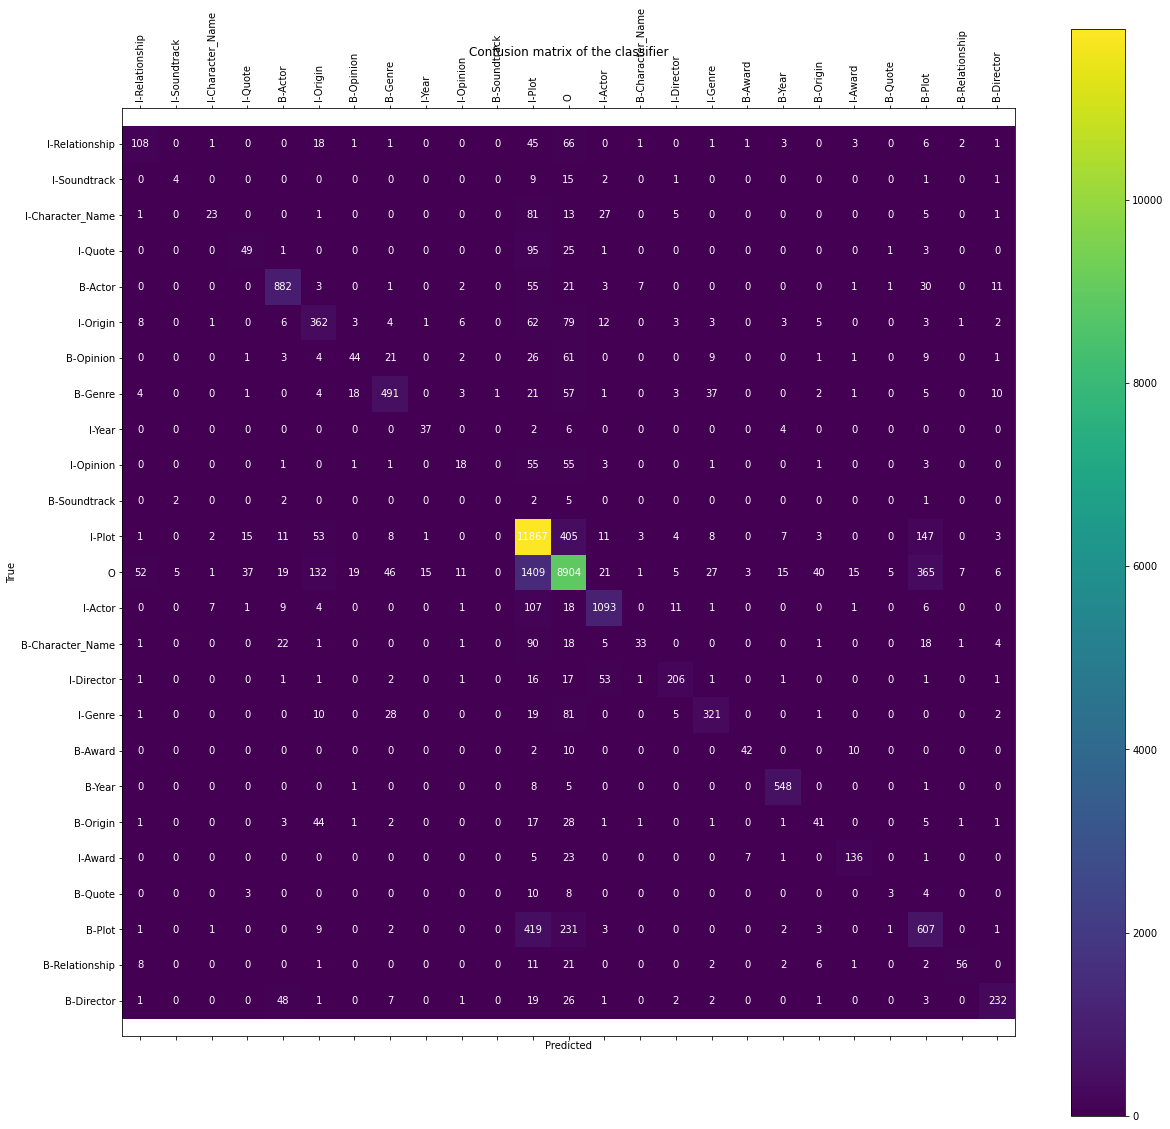

In [ ]:
print("Sentences with False positive:",count_falsepos)
print("Sentences with False negative:",count_falseneg)

confusion_matrix_heatmap(y_test_20, preds_20)

In [ ]:
#Classification report for 20% test data
print("Classification report for 20% test data:\n",classification_report(y_test_20, preds_20))
print(precision_recall_fscore_support(y_test_20, preds_20, average='macro')) 

Classification report for 20% test data:
                   precision    recall  f1-score   support

         B-Actor       0.88      0.87      0.87      1017
         B-Award       0.79      0.66      0.72        64
B-Character_Name       0.70      0.17      0.27       195
      B-Director       0.84      0.67      0.75       344
         B-Genre       0.80      0.75      0.77       659
       B-Opinion       0.50      0.24      0.32       183
        B-Origin       0.39      0.28      0.32       148
          B-Plot       0.50      0.47      0.48      1280
         B-Quote       0.27      0.11      0.15        28
  B-Relationship       0.82      0.51      0.63       110
    B-Soundtrack       0.00      0.00      0.00        12
          B-Year       0.93      0.97      0.95       563
         I-Actor       0.88      0.87      0.88      1259
         I-Award       0.80      0.79      0.80       173
I-Character_Name       0.64      0.15      0.24       157
      I-Director       0.84  

# Incorporating POS tags as features

**Altered the preprocess function to preProcess_altered and get_features function to get_features_withpostags below to add POS tags to the tokens**

In [ ]:
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")

def preProcess_altered(example):
    tokens =["@".join(pos) for pos in posttagger.tag([word[0] for word in example])] #using CRF part-of-speech (POS) tagger to join tokens with POS tags
    tags = [t[1] for t in example] #extracting BIO tags from the sentence to a list
    preprocessed_example=list(zip(tokens, tags)) # zipping both lists together

    return preprocessed_example

In [ ]:
training_data = [preProcess_altered(example) for example in train_80_split]

In [ ]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features_withpostags(tokens, idx): #Altered the get_features function to extract POS tags from the tokens
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """

    token = tokens[idx].split("@")[0] #Retrieving the token from token@POStag
    POS_tag = tokens[idx].split("@")[1] #Retrieving the POS tag from token@POStag
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])

    #Word Tag 
    feature_list.append("WORD_" + token)

    #POS Tag    
    feature_list.append("POSTAG_" + POS_tag)

    #print(feature_list)
    return feature_list

In [ ]:
# Train the CRF BIO-tag tagger

TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features_withpostags)  # initialize tagger with get_features function
print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [ ]:
#Testing tagger for 20% test data
 
# load tagger from saved file
ct = CRFTagger(feature_func=get_features_withpostags)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

test_data_20 = [preProcess_altered(example) for example in test_20_split]
print(len(test_data_20), "instances")
print(sum([len(sent) for sent in test_data_20]), "words")

print("testing tagger for 20% test data split...")
preds_20 = []
y_test_20 = []
for sent in test_data_20: 
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_20.extend(sent_preds)
    y_test_20.extend(sent_true)
print("done")

1564 instances
31890 words
testing tagger for 20% test data split...
done


In [ ]:
#Classification report for 20% test data with POS tags
print("Classification report for 20% test data:\n",classification_report(y_test_20, preds_20))
print(precision_recall_fscore_support(y_test_20, preds_20, average='macro')) 


Classification report for 20% test data:
                   precision    recall  f1-score   support

         B-Actor       0.87      0.89      0.88      1017
         B-Award       0.79      0.66      0.72        64
B-Character_Name       0.69      0.19      0.30       195
      B-Director       0.83      0.71      0.76       344
         B-Genre       0.80      0.74      0.77       659
       B-Opinion       0.51      0.26      0.35       183
        B-Origin       0.37      0.28      0.32       148
          B-Plot       0.51      0.48      0.49      1280
         B-Quote       0.33      0.11      0.16        28
  B-Relationship       0.84      0.51      0.63       110
    B-Soundtrack       0.50      0.08      0.14        12
          B-Year       0.94      0.98      0.95       563
         I-Actor       0.87      0.90      0.88      1259
         I-Award       0.84      0.79      0.81       173
I-Character_Name       0.69      0.18      0.29       157
      I-Director       0.84  

# Feature experimentation and other optimization for optimal macro average:

The experimentation of different features is done in get_features_experimentation() function below.The same preprocessing function preProcess_altered() from the above section is used for preprocessing the POS tags.

In [ ]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features_experimentation(tokens, idx): #Altered the get_features function to extract POS tags from the tokens
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    
    token = tokens[idx].split("@")[0]
    POS_tag = tokens[idx].split("@")[1]

    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Increasing the window of Suffix up to length 5
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
    if len(token) > 4:
        feature_list.append("SUF_" + token[-4:])
    if len(token) > 5:
        feature_list.append("SUF_" + token[-5:])

    #Word Tag
    feature_list.append("WORD_" + token)

    #POS Tag    
    feature_list.append("POSTAG_" + POS_tag)

    # Prefix up to length 5
    if len(token) > 1:
        feature_list.append("PRE_" + token[:1])
    if len(token) > 2:
        feature_list.append("PRE_" + token[:2])
    if len(token) > 3:
        feature_list.append("PRE_" + token[:3])
    if len(token) > 4:
        feature_list.append("PRE_" + token[:4])
    if len(token) > 5:
        feature_list.append("PRE_" + token[:5])

    #Previous word/POS tag
    if idx>1:
      Prev_token = tokens[idx-1].split("@")[0]
      Prev_pos_tag = tokens[idx-1].split("@")[1]

      feature_list.append("PREVIOUS_WORD_" + Prev_token)
      feature_list.append("PREVIOUS_POS_TAG_" + Prev_pos_tag)

    #Next word/POS tag
    if idx<(len(tokens)-2):
      Next_token =tokens[idx+1].split("@")[0]
      Next_pos_tag = tokens[idx+1].split("@")[1]

      feature_list.append("NEXT_WORD_" + Next_token)
      feature_list.append("NEXT_POS_TAG_" + Next_pos_tag)

    """
    #Previous word along with the next word #Decreased the macro average f score, hence dropped it.
    if (idx>1) and (idx<(len(tokens)-2)):
      feature_list.append(Prev_token+"_"+token+"_"+Next_token)
      feature_list.append(Prev_pos_tag+"_"+POS_tag+"_"+Next_pos_tag)
    """

    #Previous two words
    if idx>2:
      feature_list.append("PREVIOUS_TWO_WORDS_" + tokens[idx-1].split("@")[0]+"_"+tokens[idx-2].split("@")[0])

    

    #print(feature_list)
    return feature_list

In [ ]:
training_data = [preProcess_altered(example) for example in train_80_split]
test_data_20 = [preProcess_altered(example) for example in test_20_split]

Changed the minimum feature frequency 2 (rather than the default 1).The macro average F score increased to 0.625556.

In [ ]:
    TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
    ct = CRFTagger(feature_func=get_features_experimentation,training_opt={"feature.minfreq":2})  # initialize tagger with get_features function ,training_opt={"feature.minfreq":2,"c1":1.2,"c2":0}
    
    ct.train(training_data, TAGGER_PATH)
    print("done")

    #Testing tagger for 20% test data
    
    # load tagger from saved file
    #ct = CRFTagger(feature_func=get_features_experimentation)  # initialize tagger
    #ct.set_model_file(TAGGER_PATH)  # load model from file

    print("testing tagger for 20% test data split...")
    preds_20 = []
    y_test_20 = []
    for sent in test_data_20: 
        sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
        sent_true = [s[1] for s in sent]
        preds_20.extend(sent_preds)
        y_test_20.extend(sent_true)
    print(precision_recall_fscore_support(y_test_20, preds_20, average='macro'))
    print("done\n")

done
testing tagger for 20% test data split...
(0.7259083431258512, 0.5828231415111731, 0.6255565031224156, None)
done



Tried out various values for c1 and c2 regularization parameters for optimal macro average.The below code sustained for six hours before runtime of collab got disconnected for reaching its maximum duration. The values c1= 0.2 and c2=0.2 yield maximum average F score of 0.6346057 along with minimum document frequency of 2. 

In [ ]:
# Train the CRF BIO-tag tagger

L1 =[0,0.1,0.2,0.5,1,1.1,1.2,1.5]
L2 =[0,0.1,0.2,0.5,1,1.1,1.2,1.5]

for i in L1:
  for j in L2:

    TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
    ct = CRFTagger(feature_func=get_features_experimentation,training_opt={"feature.minfreq":2,"c1":i,"c2":j})  # initialize tagger with get_features function ,training_opt={"feature.minfreq":2,"c1":1.2,"c2":0}
    print("training tagger... with c1: {} and c2: {}".format(i,j))
    ct.train(training_data, TAGGER_PATH)
    print("done")

    #Testing tagger for 20% test data
    
    # load tagger from saved file
    #ct = CRFTagger(feature_func=get_features_experimentation)  # initialize tagger
    #ct.set_model_file(TAGGER_PATH)  # load model from file

    print("testing tagger for 20% test data split...")
    preds_20 = []
    y_test_20 = []
    for sent in test_data_20: 
        sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
        sent_true = [s[1] for s in sent]
        preds_20.extend(sent_preds)
        y_test_20.extend(sent_true)
    print(precision_recall_fscore_support(y_test_20, preds_20, average='macro'))
    print("done\n")


training tagger... with c1: 0 and c2: 0
done
testing tagger for 20% test data split...
(0.5101527944092203, 0.5320768417225399, 0.517949508644818, None)
done

training tagger... with c1: 0 and c2: 0.1
done
testing tagger for 20% test data split...
(0.6692393748662012, 0.6037546914099927, 0.6305928447759144, None)
done

training tagger... with c1: 0 and c2: 0.2
done
testing tagger for 20% test data split...
(0.6815542528322398, 0.5980538767098769, 0.630935769532587, None)
done

training tagger... with c1: 0 and c2: 0.5
done
testing tagger for 20% test data split...
(0.7045334154473035, 0.5923308760353507, 0.6316057697850743, None)
done

training tagger... with c1: 0 and c2: 1
done
testing tagger for 20% test data split...
(0.7259083431258512, 0.5828231415111731, 0.6255565031224156, None)
done

training tagger... with c1: 0 and c2: 1.1
done
testing tagger for 20% test data split...
(0.726318692633989, 0.5810947368607011, 0.6244017249800781, None)
done

training tagger... with c1: 0 and c

In [ ]:
    TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
    ct = CRFTagger(feature_func=get_features_experimentation,training_opt={"feature.minfreq":2,"c1":0.2,"c2":0.2})  # initialize tagger with get_features function 
    
    ct.train(training_data, TAGGER_PATH)
    print("done")

    #Testing tagger for 20% test data
    
    # load tagger from saved file
    #ct = CRFTagger(feature_func=get_features_experimentation)  # initialize tagger
    #ct.set_model_file(TAGGER_PATH)  # load model from file

    print("testing tagger for 20% test data split...minfreq=2,c1=0.2,c2=0.2")
    preds_20 = []
    y_test_20 = []
    for sent in test_data_20: 
        sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
        sent_true = [s[1] for s in sent]
        preds_20.extend(sent_preds)
        y_test_20.extend(sent_true)
    print(precision_recall_fscore_support(y_test_20, preds_20, average='macro'))
    print("done\n")

done
testing tagger for 20% test data split...minfreq=2,c1=0.2,c2=0.2
(0.6859360527106049, 0.6017014112106718, 0.6346057401023176, None)
done



In [ ]:
# Output the classification report (which you should save each time for comparing your models)

#Classification report for more features

print("Classification report for 20% test data:\n",classification_report(y_test_20, preds_20))
print(precision_recall_fscore_support(y_test_20, preds_20, average='macro')) 


Classification report for 20% test data:
                   precision    recall  f1-score   support

         B-Actor       0.93      0.92      0.93      1017
         B-Award       0.72      0.64      0.68        64
B-Character_Name       0.70      0.45      0.54       195
      B-Director       0.88      0.85      0.87       344
         B-Genre       0.82      0.80      0.81       659
       B-Opinion       0.51      0.32      0.39       183
        B-Origin       0.45      0.40      0.42       148
          B-Plot       0.50      0.48      0.49      1280
         B-Quote       0.71      0.43      0.53        28
  B-Relationship       0.81      0.53      0.64       110
    B-Soundtrack       0.17      0.08      0.11        12
          B-Year       0.95      0.98      0.97       563
         I-Actor       0.93      0.94      0.93      1259
         I-Award       0.83      0.74      0.78       173
I-Character_Name       0.66      0.45      0.54       157
      I-Director       0.92  

The confusion matrix clearly shows that the model has learned only the three most common classes I-Plot,O and I-Actor.

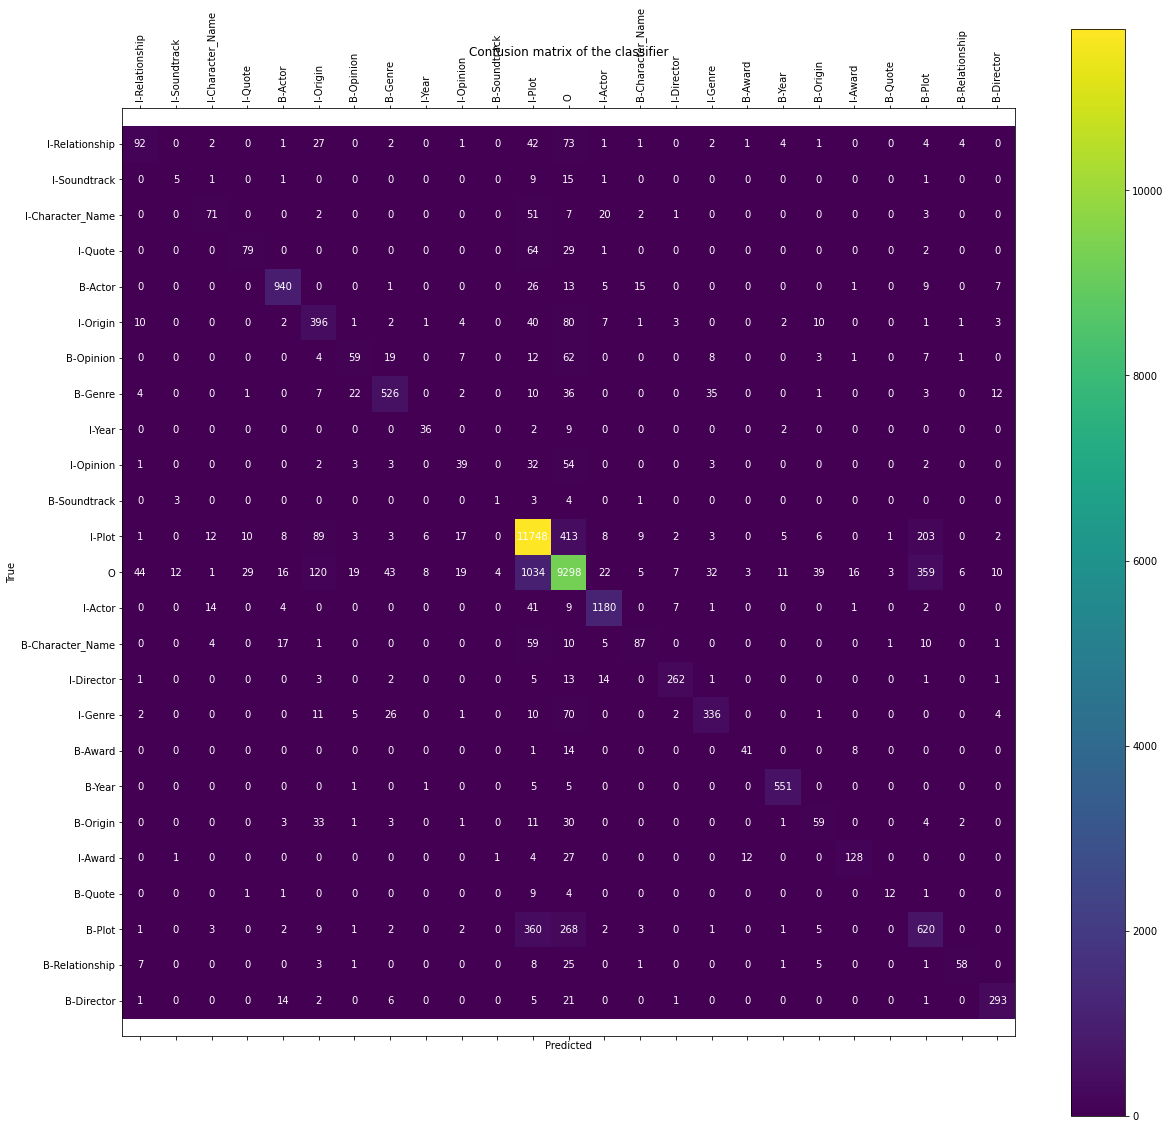

In [ ]:
confusion_matrix_heatmap(y_test_20, preds_20)

In [ ]:
# Let's see what the CRF learned by looking at the internal transition/feature weights....

In [ ]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [ ]:
print_transition_weights(ct._tagger.info().transitions.items())

10.185844 B-Actor  -> I-Actor
9.896120 B-Plot   -> I-Plot
9.879801 I-Plot   -> I-Plot
8.883671 B-Director -> I-Director
8.805091 B-Origin -> I-Origin
8.649567 I-Quote  -> I-Quote
8.586774 I-Origin -> I-Origin
8.541613 B-Quote  -> I-Quote
8.532739 B-Relationship -> I-Relationship
8.437246 I-Relationship -> I-Relationship
8.204867 B-Soundtrack -> I-Soundtrack
8.109809 B-Character_Name -> I-Character_Name
8.099512 B-Opinion -> I-Opinion
7.879210 I-Opinion -> I-Opinion
7.843009 B-Award  -> I-Award
7.790048 B-Genre  -> I-Genre
7.767793 I-Soundtrack -> I-Soundtrack
7.580794 I-Actor  -> I-Actor
7.378827 I-Genre  -> I-Genre
7.137414 I-Award  -> I-Award
6.530872 I-Character_Name -> I-Character_Name
6.130229 I-Year   -> I-Year
5.955608 I-Director -> I-Director
5.039828 B-Year   -> I-Year
4.637589 O        -> O
3.939719 B-Character_Name -> B-Plot
3.676948 O        -> B-Plot
3.477158 B-Plot   -> B-Character_Name
3.287798 O        -> B-Genre
3.052915 O        -> B-Director
3.025440 O        -> B-Ch

In [ ]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)  # assume we want to print all of them
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    for (attr, label), weight in ranked_state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [ ]:
print_most_predictive_state_features(ct._tagger.info().state_features.items())

Streaming output truncated to the last 5000 lines.
-0.041185 B-Plot   PREVIOUS_TWO_WORDS_character_title
-0.041300 B-Genre  SUF_f
-0.041300 B-Genre  NEXT_WORD_documentary
-0.041376 B-Plot   NEXT_WORD_bunch
-0.041397 I-Opinion SUF_st
-0.041468 B-Genre  NEXT_WORD_science
-0.041476 I-Plot   PRE_s
-0.041669 B-Plot   PRE_mad
-0.041711 I-Plot   SUF_lves
-0.041727 I-Origin NEXT_POS_TAG_NN
-0.041849 I-Plot   SUF_fore
-0.041849 I-Plot   SUF_efore
-0.041985 I-Genre  PREVIOUS_TWO_WORDS_animated_classic
-0.041999 I-Plot   PREVIOUS_WORD_themed
-0.042024 B-Plot   NEXT_WORD_must
-0.042060 I-Award  PRE_f
-0.042186 I-Plot   SUF_anks
-0.042271 I-Director NEXT_WORD_science
-0.042407 I-Genre  PRE_ki
-0.042424 B-Actor  SUF_nneth
-0.042424 B-Actor  WORD_kenneth
-0.042739 B-Plot   SUF_ice
-0.042835 I-Plot   PREVIOUS_WORD_rural
-0.042855 I-Origin PRE_wi
-0.042856 B-Origin PRE_pa
-0.043140 I-Plot   PREVIOUS_TWO_WORDS_a_start
-0.043256 I-Plot   NEXT_WORD_boat
-0.043329 I-Plot   PRE_ov
-0.043329 I-Plot   PRE_ove

In [ ]:
# Final results on original test data, using all training data, with best settings from dev set:

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess_altered(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")


# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features_experimentation,training_opt={"feature.minfreq":2,"c1":0.2,"c2":0.2})  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features_experimentation)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

print("testing tagger on test data...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

1953 instances
39035 words
training tagger...
done
1953 instances
39035 words
testing tagger on test data...
done


In [ ]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

                  precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.93      1274
         B-Award       0.73      0.68      0.70        66
B-Character_Name       0.68      0.46      0.55       283
      B-Director       0.87      0.86      0.86       425
         B-Genre       0.81      0.80      0.81       789
       B-Opinion       0.47      0.39      0.43       195
        B-Origin       0.47      0.39      0.42       190
          B-Plot       0.50      0.49      0.49      1577
         B-Quote       0.82      0.38      0.52        47
  B-Relationship       0.72      0.53      0.61       171
    B-Soundtrack       0.50      0.12      0.20         8
          B-Year       0.96      0.97      0.97       661
         I-Actor       0.92      0.94      0.93      1553
         I-Award       0.79      0.78      0.79       147
I-Character_Name       0.70      0.50      0.58       227
      I-Director       0.91      0.87      0.89       411
         I-Ge

In [ ]:
'''
Comparision of classification report after addition of each feature

1. Original on test: (0.7315480207626757, 0.5462735704323516, 0.5893746715424786, None)

2. After 80-20 split: (0.6436405657076234, 0.5179919373867895, 0.5550305053863744, None)

Classification report for 20% test data:
                   precision    recall  f1-score   support

         B-Actor       0.88      0.87      0.87      1017
         B-Award       0.79      0.66      0.72        64
B-Character_Name       0.70      0.17      0.27       195
      B-Director       0.84      0.67      0.75       344
         B-Genre       0.80      0.75      0.77       659
       B-Opinion       0.50      0.24      0.32       183
        B-Origin       0.39      0.28      0.32       148
          B-Plot       0.50      0.47      0.48      1280
         B-Quote       0.27      0.11      0.15        28
  B-Relationship       0.82      0.51      0.63       110
    B-Soundtrack       0.00      0.00      0.00        12
          B-Year       0.93      0.97      0.95       563
         I-Actor       0.88      0.87      0.88      1259
         I-Award       0.80      0.79      0.80       173
I-Character_Name       0.64      0.15      0.24       157
      I-Director       0.84      0.68      0.75       303
         I-Genre       0.78      0.69      0.73       468
       I-Opinion       0.39      0.13      0.19       139
        I-Origin       0.56      0.64      0.60       564
          I-Plot       0.82      0.95      0.88     12549
         I-Quote       0.46      0.28      0.35       175
  I-Relationship       0.57      0.42      0.48       258
    I-Soundtrack       0.36      0.12      0.18        33
          I-Year       0.69      0.76      0.72        49
               O       0.87      0.80      0.83     11160

        accuracy                           0.82     31890
       macro avg       0.64      0.52      0.56     31890
    weighted avg       0.81      0.82      0.81     31890

(0.6436405657076234, 0.5179919373867895, 0.5550305053863744, None)


3. After POS tags :(0.6877488693982469, 0.5352072438400586, 0.5772032974093535, None)


Classification report for 20% test data:
                   precision    recall  f1-score   support

         B-Actor       0.87      0.89      0.88      1017
         B-Award       0.79      0.66      0.72        64
B-Character_Name       0.69      0.19      0.30       195
      B-Director       0.83      0.71      0.76       344
         B-Genre       0.80      0.74      0.77       659
       B-Opinion       0.51      0.26      0.35       183
        B-Origin       0.37      0.28      0.32       148
          B-Plot       0.51      0.48      0.49      1280
         B-Quote       0.33      0.11      0.16        28
  B-Relationship       0.84      0.51      0.63       110
    B-Soundtrack       0.50      0.08      0.14        12
          B-Year       0.94      0.98      0.95       563
         I-Actor       0.87      0.90      0.88      1259
         I-Award       0.84      0.79      0.81       173
I-Character_Name       0.69      0.18      0.29       157
      I-Director       0.84      0.72      0.77       303
         I-Genre       0.77      0.68      0.72       468
       I-Opinion       0.42      0.13      0.20       139
        I-Origin       0.53      0.64      0.58       564
          I-Plot       0.83      0.95      0.88     12549
         I-Quote       0.54      0.25      0.34       175
  I-Relationship       0.65      0.42      0.51       258
    I-Soundtrack       0.69      0.27      0.39        33
          I-Year       0.69      0.76      0.72        49
               O       0.88      0.80      0.84     11160

        accuracy                           0.82     31890
       macro avg       0.69      0.54      0.58     31890
    weighted avg       0.82      0.82      0.82     31890

(0.6877488693982469, 0.5352072438400586, 0.5772032974093535, None)

4. After Prefix tags : (0.6893443475998287, 0.5537043688129851, 0.5955726805338757, None)

Classification report for 20% test data:
                   precision    recall  f1-score   support

         B-Actor       0.88      0.90      0.89      1017
         B-Award       0.79      0.66      0.72        64
B-Character_Name       0.63      0.27      0.38       195
      B-Director       0.83      0.74      0.78       344
         B-Genre       0.81      0.76      0.78       659
       B-Opinion       0.47      0.27      0.34       183
        B-Origin       0.38      0.29      0.33       148
          B-Plot       0.51      0.48      0.49      1280
         B-Quote       0.45      0.18      0.26        28
  B-Relationship       0.86      0.54      0.66       110
    B-Soundtrack       0.67      0.17      0.27        12
          B-Year       0.96      0.98      0.97       563
         I-Actor       0.88      0.92      0.90      1259
         I-Award       0.82      0.77      0.80       173
I-Character_Name       0.57      0.27      0.37       157
      I-Director       0.85      0.75      0.80       303
         I-Genre       0.77      0.69      0.73       468
       I-Opinion       0.53      0.14      0.22       139
        I-Origin       0.53      0.62      0.57       564
          I-Plot       0.84      0.94      0.89     12549
         I-Quote       0.55      0.27      0.36       175
  I-Relationship       0.58      0.41      0.48       258
    I-Soundtrack       0.50      0.24      0.33        33
          I-Year       0.72      0.78      0.75        49
               O       0.87      0.81      0.84     11160

        accuracy                           0.83     31890
       macro avg       0.69      0.55      0.60     31890
    weighted avg       0.82      0.83      0.82     31890

(0.6893443475998287, 0.5537043688129851, 0.5955726805338757, None)

5. After Increasing Prefix/Suffix window to 5: (0.6816924918127267, 0.5555371080245596, 0.5960311629286998, None)

Classification report for 20% test data:
                   precision    recall  f1-score   support

         B-Actor       0.89      0.90      0.90      1017
         B-Award       0.78      0.66      0.71        64
B-Character_Name       0.71      0.30      0.42       195
      B-Director       0.83      0.76      0.79       344
         B-Genre       0.81      0.77      0.79       659
       B-Opinion       0.49      0.31      0.38       183
        B-Origin       0.39      0.31      0.35       148
          B-Plot       0.51      0.48      0.49      1280
         B-Quote       0.55      0.21      0.31        28
  B-Relationship       0.81      0.53      0.64       110
    B-Soundtrack       0.33      0.08      0.13        12
          B-Year       0.96      0.98      0.97       563
         I-Actor       0.89      0.92      0.91      1259
         I-Award       0.83      0.77      0.80       173
I-Character_Name       0.64      0.27      0.38       157
      I-Director       0.85      0.77      0.81       303
         I-Genre       0.78      0.68      0.72       468
       I-Opinion       0.46      0.14      0.21       139
        I-Origin       0.54      0.62      0.58       564
          I-Plot       0.84      0.94      0.89     12549
         I-Quote       0.62      0.30      0.40       175
  I-Relationship       0.55      0.38      0.45       258
    I-Soundtrack       0.39      0.21      0.27        33
          I-Year       0.73      0.78      0.75        49
               O       0.87      0.82      0.84     11160

        accuracy                           0.83     31890
       macro avg       0.68      0.56      0.60     31890
    weighted avg       0.83      0.83      0.82     31890

(0.6816924918127267, 0.5555371080245596, 0.5960311629286998, None)

6. After adding previous word and POS tag : (0.682378574404966, 0.5686558970331458, 0.6104518564511373, None)

Classification report for 20% test data:
                   precision    recall  f1-score   support

         B-Actor       0.91      0.92      0.92      1017
         B-Award       0.80      0.67      0.73        64
B-Character_Name       0.72      0.38      0.50       195
      B-Director       0.87      0.80      0.83       344
         B-Genre       0.84      0.77      0.81       659
       B-Opinion       0.49      0.35      0.41       183
        B-Origin       0.43      0.35      0.39       148
          B-Plot       0.51      0.49      0.50      1280
         B-Quote       0.85      0.39      0.54        28
  B-Relationship       0.78      0.53      0.63       110
    B-Soundtrack       0.00      0.00      0.00        12
          B-Year       0.96      0.98      0.97       563
         I-Actor       0.91      0.94      0.93      1259
         I-Award       0.85      0.76      0.80       173
I-Character_Name       0.66      0.37      0.47       157
      I-Director       0.90      0.81      0.85       303
         I-Genre       0.79      0.70      0.74       468
       I-Opinion       0.44      0.15      0.22       139
        I-Origin       0.56      0.66      0.61       564
          I-Plot       0.85      0.95      0.90     12549
         I-Quote       0.68      0.41      0.51       175
  I-Relationship       0.58      0.36      0.44       258
    I-Soundtrack       0.00      0.00      0.00        33
          I-Year       0.80      0.65      0.72        49
               O       0.88      0.82      0.85     11160

        accuracy                           0.84     31890
       macro avg       0.68      0.57      0.61     31890
    weighted avg       0.84      0.84      0.84     31890

(0.682378574404966, 0.5686558970331458, 0.6104518564511373, None)


7. After adding next word and POS tag :(0.6859152433364858, 0.5705651749143386, 0.612468497338876, None)

Classification report for 20% test data:
                   precision    recall  f1-score   support

         B-Actor       0.93      0.92      0.93      1017
         B-Award       0.75      0.64      0.69        64
B-Character_Name       0.75      0.39      0.51       195
      B-Director       0.88      0.82      0.85       344
         B-Genre       0.83      0.79      0.81       659
       B-Opinion       0.50      0.34      0.41       183
        B-Origin       0.46      0.37      0.41       148
          B-Plot       0.50      0.49      0.50      1280
         B-Quote       0.75      0.32      0.45        28
  B-Relationship       0.82      0.55      0.66       110
    B-Soundtrack       0.00      0.00      0.00        12
          B-Year       0.96      0.97      0.97       563
         I-Actor       0.93      0.94      0.93      1259
         I-Award       0.85      0.73      0.79       173
I-Character_Name       0.71      0.41      0.52       157
      I-Director       0.91      0.84      0.87       303
         I-Genre       0.80      0.71      0.75       468
       I-Opinion       0.58      0.21      0.31       139
        I-Origin       0.60      0.69      0.64       564
          I-Plot       0.85      0.95      0.90     12549
         I-Quote       0.60      0.34      0.44       175
  I-Relationship       0.56      0.39      0.46       258
    I-Soundtrack       0.00      0.00      0.00        33
          I-Year       0.76      0.63      0.69        49
               O       0.88      0.83      0.85     11160

        accuracy                           0.84     31890
       macro avg       0.69      0.57      0.61     31890
    weighted avg       0.84      0.84      0.84     31890

(0.6859152433364858, 0.5705651749143386, 0.612468497338876, None)

8. After adding both previous/next word and tag : #Discarded

Classification report for 20% test data:
                   precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.92      1017
         B-Award       0.71      0.62      0.67        64
B-Character_Name       0.73      0.36      0.48       195
      B-Director       0.87      0.81      0.84       344
         B-Genre       0.83      0.79      0.81       659
       B-Opinion       0.50      0.32      0.39       183
        B-Origin       0.48      0.39      0.43       148
          B-Plot       0.50      0.49      0.49      1280
         B-Quote       0.75      0.32      0.45        28
  B-Relationship       0.82      0.55      0.66       110
    B-Soundtrack       0.00      0.00      0.00        12
          B-Year       0.96      0.97      0.96       563
         I-Actor       0.92      0.95      0.93      1259
         I-Award       0.82      0.73      0.78       173
I-Character_Name       0.69      0.37      0.48       157
      I-Director       0.90      0.83      0.86       303
         I-Genre       0.80      0.70      0.75       468
       I-Opinion       0.64      0.24      0.35       139
        I-Origin       0.60      0.70      0.65       564
          I-Plot       0.85      0.94      0.89     12549
         I-Quote       0.70      0.34      0.46       175
  I-Relationship       0.58      0.39      0.47       258
    I-Soundtrack       0.00      0.00      0.00        33
          I-Year       0.76      0.63      0.69        49
               O       0.88      0.82      0.85     11160

        accuracy                           0.84     31890
       macro avg       0.69      0.57      0.61     31890
    weighted avg       0.84      0.84      0.84     31890

(0.688847199426576, 0.5675504936164545, 0.6104984775434924, None)

9. After adding two previous words:(0.7028223485538416, 0.5789806812566174, 0.6212861182879316, None)

Classification report for 20% test data:
                   precision    recall  f1-score   support

         B-Actor       0.93      0.93      0.93      1017
         B-Award       0.73      0.64      0.68        64
B-Character_Name       0.77      0.39      0.52       195
      B-Director       0.90      0.84      0.87       344
         B-Genre       0.83      0.80      0.81       659
       B-Opinion       0.50      0.32      0.39       183
        B-Origin       0.46      0.38      0.41       148
          B-Plot       0.51      0.49      0.50      1280
         B-Quote       0.71      0.36      0.48        28
  B-Relationship       0.82      0.55      0.66       110
    B-Soundtrack       0.00      0.00      0.00        12
          B-Year       0.95      0.97      0.96       563
         I-Actor       0.93      0.94      0.93      1259
         I-Award       0.85      0.72      0.78       173
I-Character_Name       0.74      0.41      0.52       157
      I-Director       0.93      0.87      0.90       303
         I-Genre       0.79      0.71      0.75       468
       I-Opinion       0.54      0.18      0.27       139
        I-Origin       0.59      0.70      0.64       564
          I-Plot       0.86      0.95      0.90     12549
         I-Quote       0.59      0.38      0.47       175
  I-Relationship       0.59      0.38      0.46       258
    I-Soundtrack       0.43      0.09      0.15        33
          I-Year       0.73      0.65      0.69        49
               O       0.88      0.83      0.85     11160

        accuracy                           0.84     31890
       macro avg       0.70      0.58      0.62     31890
    weighted avg       0.84      0.84      0.84     31890

(0.7028223485538416, 0.5789806812566174, 0.6212861182879316, None)

10. After minimum document frequency =2, with two previous words: :(0.7259083431258512, 0.5828231415111731, 0.6255565031224156, None)

Classification report for 20% test data:
                   precision    recall  f1-score   support

         B-Actor       0.93      0.92      0.93      1017
         B-Award       0.73      0.64      0.68        64
B-Character_Name       0.70      0.38      0.49       195
      B-Director       0.89      0.84      0.86       344
         B-Genre       0.84      0.79      0.81       659
       B-Opinion       0.49      0.31      0.38       183
        B-Origin       0.47      0.40      0.43       148
          B-Plot       0.52      0.50      0.51      1280
         B-Quote       0.71      0.36      0.48        28
  B-Relationship       0.83      0.54      0.65       110
    B-Soundtrack       0.50      0.08      0.14        12
          B-Year       0.95      0.97      0.96       563
         I-Actor       0.93      0.94      0.94      1259
         I-Award       0.85      0.72      0.78       173
I-Character_Name       0.64      0.37      0.47       157
      I-Director       0.92      0.86      0.89       303
         I-Genre       0.79      0.71      0.75       468
       I-Opinion       0.41      0.20      0.27       139
        I-Origin       0.58      0.73      0.65       564
          I-Plot       0.86      0.94      0.90     12549
         I-Quote       0.64      0.40      0.49       175
  I-Relationship       0.60      0.37      0.46       258
    I-Soundtrack       0.75      0.09      0.16        33
          I-Year       0.73      0.67      0.70        49
               O       0.88      0.83      0.86     11160

        accuracy                           0.85     31890
       macro avg       0.73      0.58      0.63     31890
    weighted avg       0.84      0.85      0.84     31890

(0.7259083431258512, 0.5828231415111731, 0.6255565031224156, None)


11. After minimum document frequency =2, without two previous words:
(0.7024303084967769, 0.5729059050748496, 0.6145478853080343, None)

12. After minimum document frequency =2 , c1=0.2,c2=0.2: (0.6859360527106049, 0.6017014112106718, 0.6346057401023176, None)

Classification report for 20% test data:
                   precision    recall  f1-score   support

         B-Actor       0.93      0.92      0.93      1017
         B-Award       0.72      0.64      0.68        64
B-Character_Name       0.70      0.45      0.54       195
      B-Director       0.88      0.85      0.87       344
         B-Genre       0.82      0.80      0.81       659
       B-Opinion       0.51      0.32      0.39       183
        B-Origin       0.45      0.40      0.42       148
          B-Plot       0.50      0.48      0.49      1280
         B-Quote       0.71      0.43      0.53        28
  B-Relationship       0.81      0.53      0.64       110
    B-Soundtrack       0.17      0.08      0.11        12
          B-Year       0.95      0.98      0.97       563
         I-Actor       0.93      0.94      0.93      1259
         I-Award       0.83      0.74      0.78       173
I-Character_Name       0.66      0.45      0.54       157
      I-Director       0.92      0.86      0.89       303
         I-Genre       0.80      0.72      0.76       468
       I-Opinion       0.42      0.28      0.34       139
        I-Origin       0.56      0.70      0.62       564
          I-Plot       0.86      0.94      0.90     12549
         I-Quote       0.66      0.45      0.54       175
  I-Relationship       0.56      0.36      0.44       258
    I-Soundtrack       0.24      0.15      0.19        33
          I-Year       0.69      0.73      0.71        49
               O       0.88      0.83      0.86     11160

        accuracy                           0.84     31890
       macro avg       0.69      0.60      0.63     31890
    weighted avg       0.84      0.84      0.84     31890

(0.6859360527106049, 0.6017014112106718, 0.6346057401023176, None)

13. Final classification report on the testing data:(0.70267367738504, 0.6012097912711769, 0.6356852693153364, None)

               precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.93      1274
         B-Award       0.73      0.68      0.70        66
B-Character_Name       0.68      0.46      0.55       283
      B-Director       0.87      0.86      0.86       425
         B-Genre       0.81      0.80      0.81       789
       B-Opinion       0.47      0.39      0.43       195
        B-Origin       0.47      0.39      0.42       190
          B-Plot       0.50      0.49      0.49      1577
         B-Quote       0.82      0.38      0.52        47
  B-Relationship       0.72      0.53      0.61       171
    B-Soundtrack       0.50      0.12      0.20         8
          B-Year       0.96      0.97      0.97       661
         I-Actor       0.92      0.94      0.93      1553
         I-Award       0.79      0.78      0.79       147
I-Character_Name       0.70      0.50      0.58       227
      I-Director       0.91      0.87      0.89       411
         I-Genre       0.79      0.74      0.77       544
       I-Opinion       0.26      0.18      0.21       143
        I-Origin       0.64      0.65      0.64       808
          I-Plot       0.86      0.94      0.90     14661
         I-Quote       0.81      0.51      0.62       349
  I-Relationship       0.51      0.41      0.45       289
    I-Soundtrack       0.43      0.10      0.16        30
          I-Year       0.62      0.57      0.60        44
               O       0.88      0.84      0.86     14143

        accuracy                           0.84     39035
       macro avg       0.70      0.60      0.64     39035
    weighted avg       0.84      0.84      0.84     39035

(0.70267367738504, 0.6012097912711769, 0.6356852693153364, None)



'''